In [7]:
import os
from os.path import dirname
import numpy as np
from scipy.signal import find_peaks
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.optimize import curve_fit
import seaborn as sns

sns.set(color_codes=True, style="white")
pd.options.mode.chained_assignment = None  # default='warn'

folder_save = "/Volumes/lsa-nwalter/Guoming_Gao_turbo/Walterlab_server/PROCESSED_DATA/RNA-diffusion-in-FUS/RNAinFUS_PaperFigures/Fig_SM_static_loc_error"
nm_per_pixel = 117

- standard deviation of the position, representing static localization error.
- synchronize the mean position of each track to (0,0), then pool all spot coordinates together and get a 2D histogram, fit to a 2D Gaussian and find the sigma, which is the static localization error.
- calculate STD for each track, and filter out all moving tracks with STD > 200 nm because the ground truth is molecules are not moving and the "moving" molecules could be (1) binding-unbinding events, and (2) cluster of RNA that is too large and confuses our blob detector at d=3.

## Combine dataframes

In [8]:
os.chdir(folder_save)
lst_files = [f for f in os.listdir(".") if f.endswith(".csv")]

#### synchronize tracks to average position

In [9]:
x_sync = []
y_sync = []
for f in lst_files:
    df = pd.read_csv(f)
    trackids = list(df.trackID.unique())
    for idx in trackids:
        df_track = df[df.trackID == idx]
        try:
            x_nm = df_track.x.to_numpy(dtype=float) * nm_per_pixel
            y_nm = df_track.y.to_numpy(dtype=float) * nm_per_pixel
        except:
            print(f)
        meanx = x_nm.mean()
        meany = y_nm.mean()
        dx = x_nm - meanx
        dy = y_nm - meany
        singleRNA_std = np.sqrt(np.nanmean(dx**2 + dy**2))
        if singleRNA_std > 200:
            continue
        else:
            x_sync.extend(dx)
            y_sync.extend(dy)

# Plots

### bin the 2D distribution of x_sync and y_sync into 2D histogram and plot as heatmap

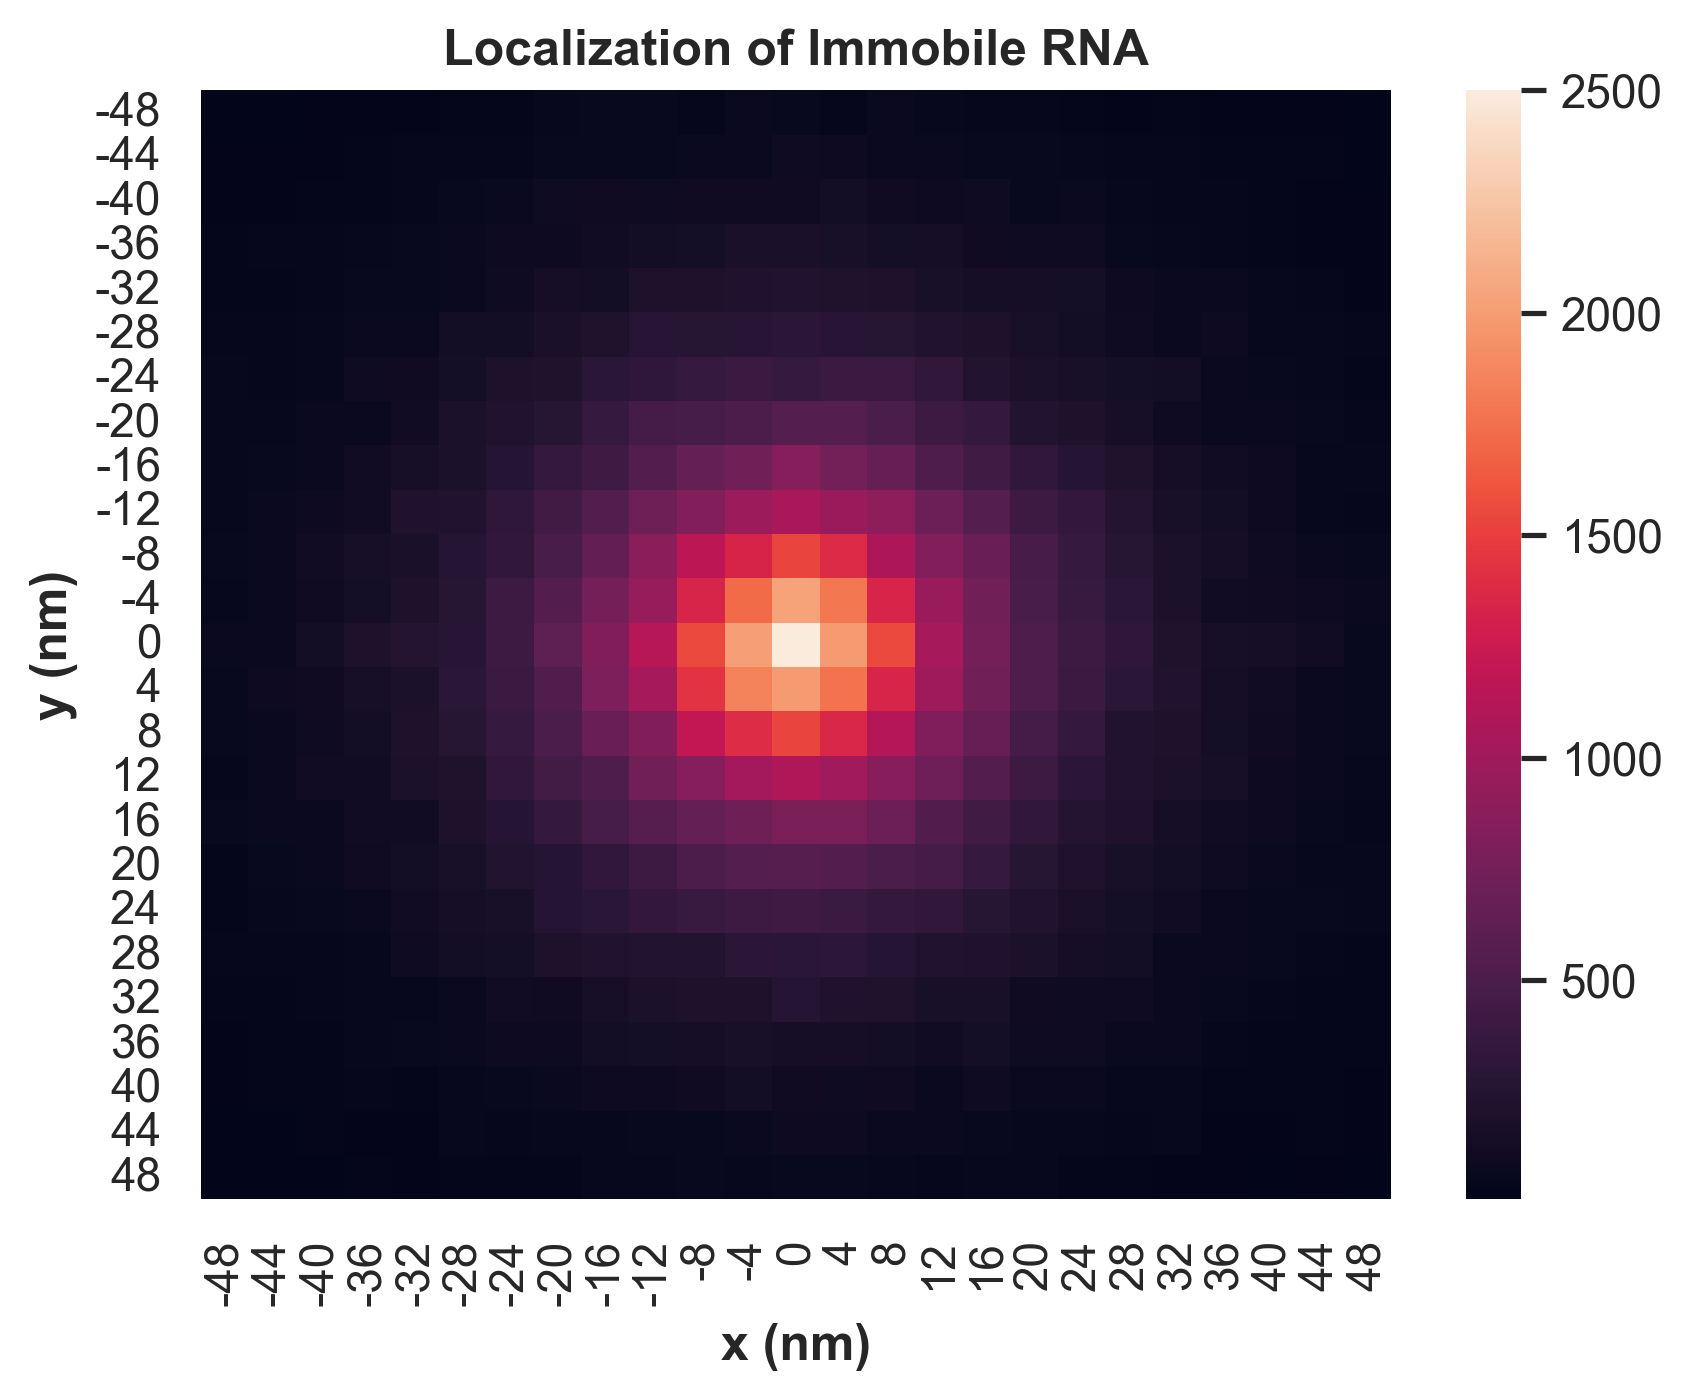

In [13]:
edges = np.arange(-50, 52, 4)
idx_center = round(len(edges) / 2) - 1
H, _, _ = np.histogram2d(x_sync, y_sync, bins=[edges, edges])

plt.figure(dpi=300)
ticks = (edges[1:] + edges[:-1]) / 2
ticks = ticks.astype(int)
sns.heatmap(H, xticklabels=ticks, yticklabels=ticks)
# plt.xticks([-30, 0, 30])
plt.xlabel("x (nm)", weight="bold")
plt.ylabel("y (nm)", weight="bold")
plt.title("Localization of Immobile RNA", weight="bold")
plt.savefig("Localization of Immobile RNA.png", format="png", bbox_inches="tight")
plt.show()

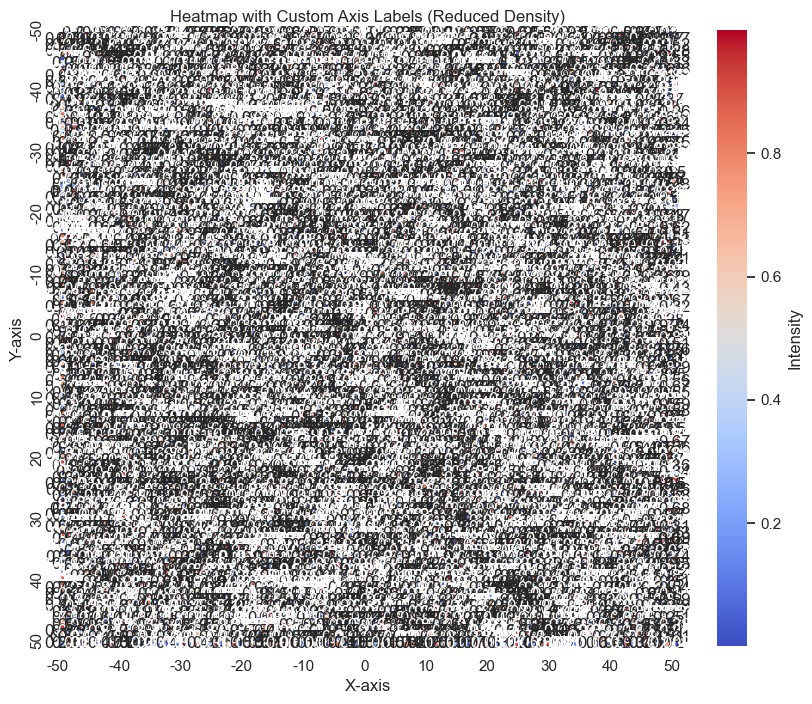

In [17]:
# Generate random data for the heatmap
data = np.random.rand(101, 101)  # Adjust the size according to your data

# Create a heatmap using Seaborn
plt.figure(figsize=(10, 8))

# Define the step size for x and y axis labels
x_step = 10
y_step = 10

# Create custom x and y axis labels using step size
x_labels = np.arange(-50, 51, x_step)
y_labels = np.arange(-50, 51, y_step)

# Create the heatmap with custom x and y labels
heatmap = sns.heatmap(
    data, annot=True, cmap="coolwarm", linewidths=0.5, cbar_kws={"label": "Intensity"}
)

# Set custom x and y axis ticks
heatmap.set_xticks(np.linspace(0, 100, len(x_labels)))
heatmap.set_yticks(np.linspace(0, 100, len(y_labels)))

# Set the tick labels to match your custom labels
heatmap.set_xticklabels(x_labels)
heatmap.set_yticklabels(y_labels)

plt.title("Heatmap with Custom Axis Labels (Reduced Density)")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")

plt.show()

### Localization error

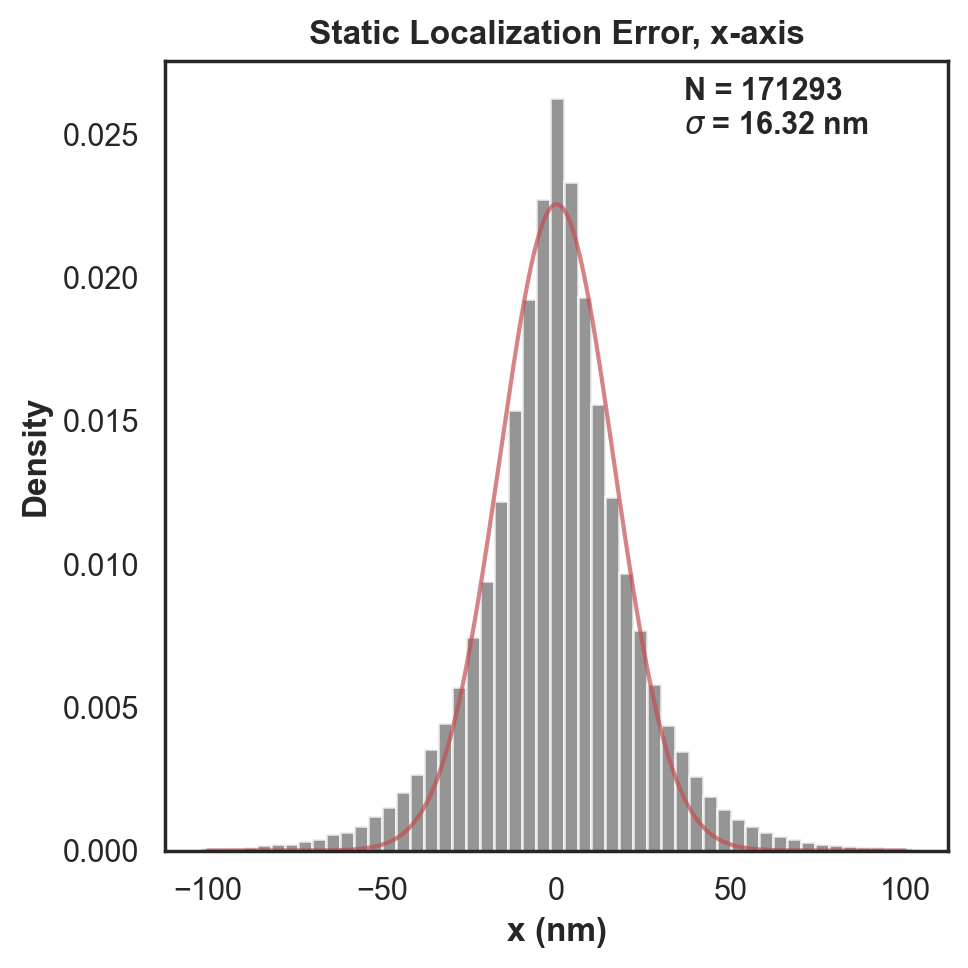

In [20]:
def Gauss_centered(x, A, sigma):
    return A * np.exp((-1 / 2) * ((x / sigma) ** 2))


edges = np.arange(-102, 104, 4)
ticks = (edges[1:] + edges[:-1]) / 2
ticks = ticks.astype(int)
plt.figure(figsize=(5, 5), dpi=200)
density, _, _ = plt.hist(x_sync, bins=edges, color="dimgray", alpha=0.7, density=True)
(A, sigma), covariance = curve_fit(Gauss_centered, ticks, density)
curve_x = np.arange(ticks[0], ticks[-1], 0.1)
curve_y = Gauss_centered(curve_x, A, sigma)
plt.plot(curve_x, curve_y, color=sns.color_palette()[3], alpha=0.7)
text = "N = " + str(len(x_sync)) + "\n" + "$\sigma$ = " + str(round(sigma, 2)) + " nm"
plt.text(
    0.7, 0.85, text, fontsize=11, transform=plt.gcf().transFigure, weight="bold",
)
plt.title("Static Localization Error, x-axis", weight="bold")
plt.xlabel("x (nm)", weight="bold")
plt.ylabel("Density", weight="bold")
plt.tight_layout()
plt.savefig("Static Localization Error-x.png", format="png")
plt.show()

### Maximum Distance (whether static molecule)

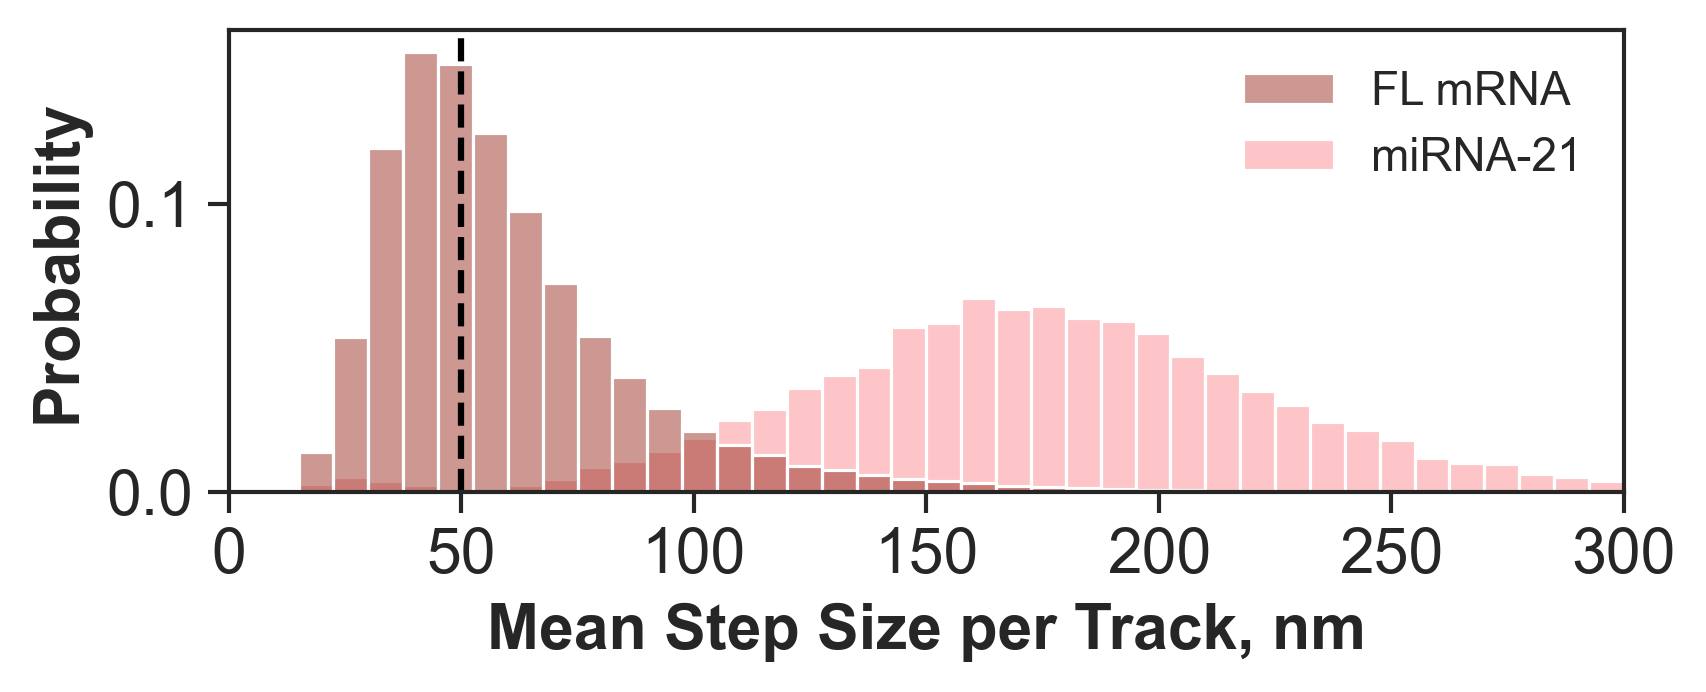

FL mRNA 11331
miRNA-21 13793


In [23]:
plt.figure(figsize=(6, 2), dpi=300)
ax = sns.histplot(
    data=df_AIO,
    x="mean_stepsize_nm",
    hue="label",
    palette=palette,
    bins=40,
    stat="probability",
    common_norm=False,
    binrange=(0, 300),
    alpha=0.5,
)
plt.xlim(0, 300)
sns.move_legend(ax, 0, title=None, frameon=False)
plt.axvline(50, ls="--", color="black")
plt.xlabel("Mean Step Size per Track, nm", weight="bold", fontsize=15)
plt.ylabel("Probability", weight="bold", fontsize=15)
plt.gca().spines[:].set_linewidth(1)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=15,
    direction="out",
    bottom=True,
    left=True,
    length=5,
    width=1,
)

plt.gca().tick_params(axis="both", which="major", labelsize=15)
plt.savefig("2.mean_stepsize_nm_histo_" + postfix, format="png", bbox_inches="tight")
plt.show()
print(label_1, data[data["label"] == label_1].shape[0])
print(label_2, data[data["label"] == label_2].shape[0])

### alpha distribution

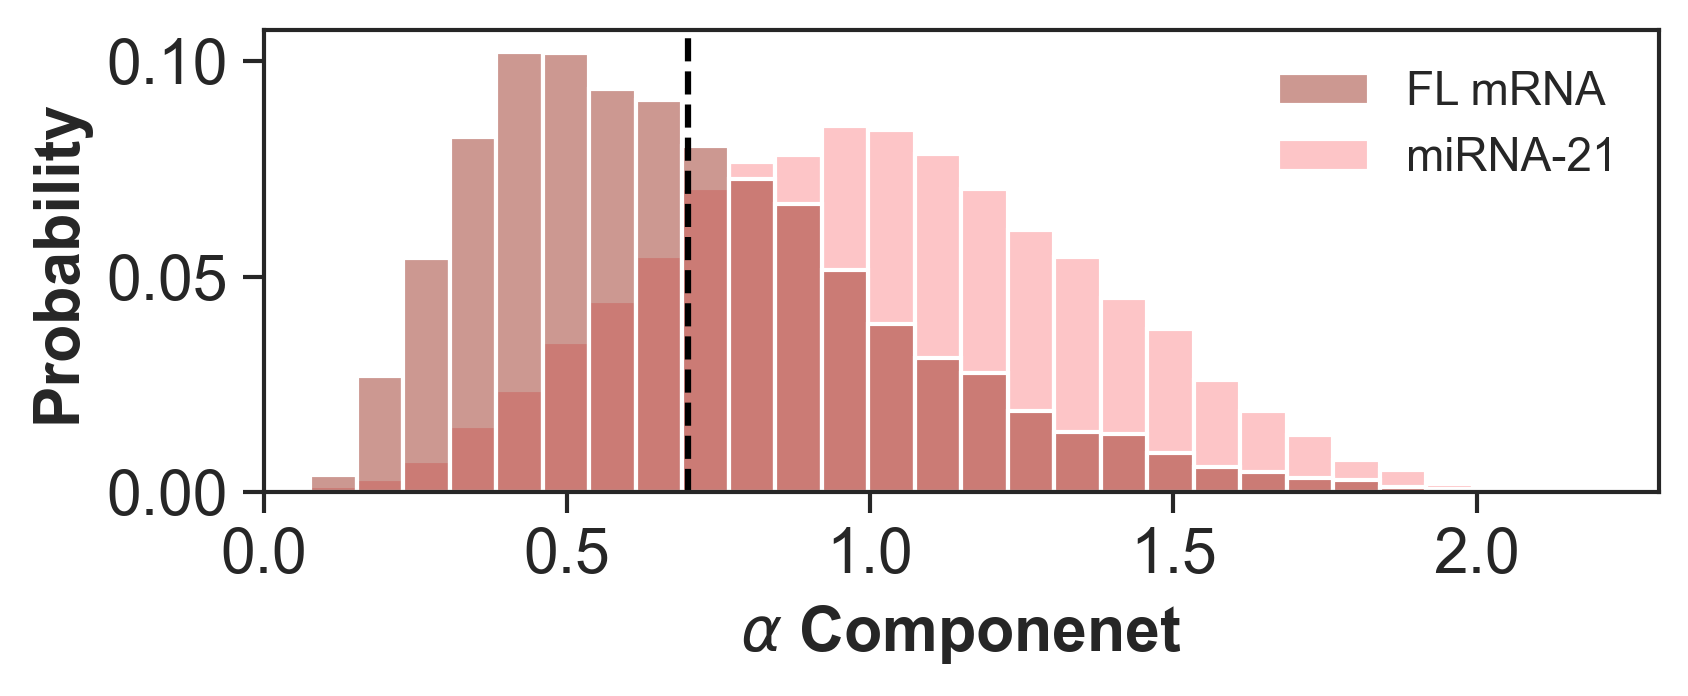

FL mRNA 11096
miRNA-21 14390


In [6]:
plt.figure(figsize=(6, 2), dpi=300)
data = df_AIO[df_AIO["max_d_anytwo_nm"] > threshold_max_d_anytwo_nm]
data = data[data["loglog_fit_R2"] > 0.7]
data = data[data["alpha"] > 0]
ax = sns.histplot(
    data=data,
    x="alpha",
    hue="label",
    palette=palette,
    bins=30,
    stat="probability",
    common_norm=False,
    binrange=(0, 2.3),
    # kde=True,
    # kde_kws={"bw_adjust": 1.5},
    # line_kws={"lw": 3},
    alpha=0.5,
)
sns.move_legend(ax, 0, title=None, frameon=False)
plt.axvline(0.7, ls="--", color="black")
plt.xlim(0, 2.3)
plt.xlabel(r"$\alpha$ Componenet", weight="bold", fontsize=15)
plt.ylabel("Probability", weight="bold", fontsize=15)
plt.gca().spines[:].set_linewidth(1)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=15,
    direction="out",
    bottom=True,
    left=True,
    length=5,
    width=1,
)

plt.gca().tick_params(axis="both", which="major", labelsize=15)
plt.savefig("3.alpha_histo_" + postfix, format="png", bbox_inches="tight")
plt.show()
print(label_1, data[data["label"] == label_1].shape[0])
print(label_2, data[data["label"] == label_2].shape[0])

### Angle Distribution

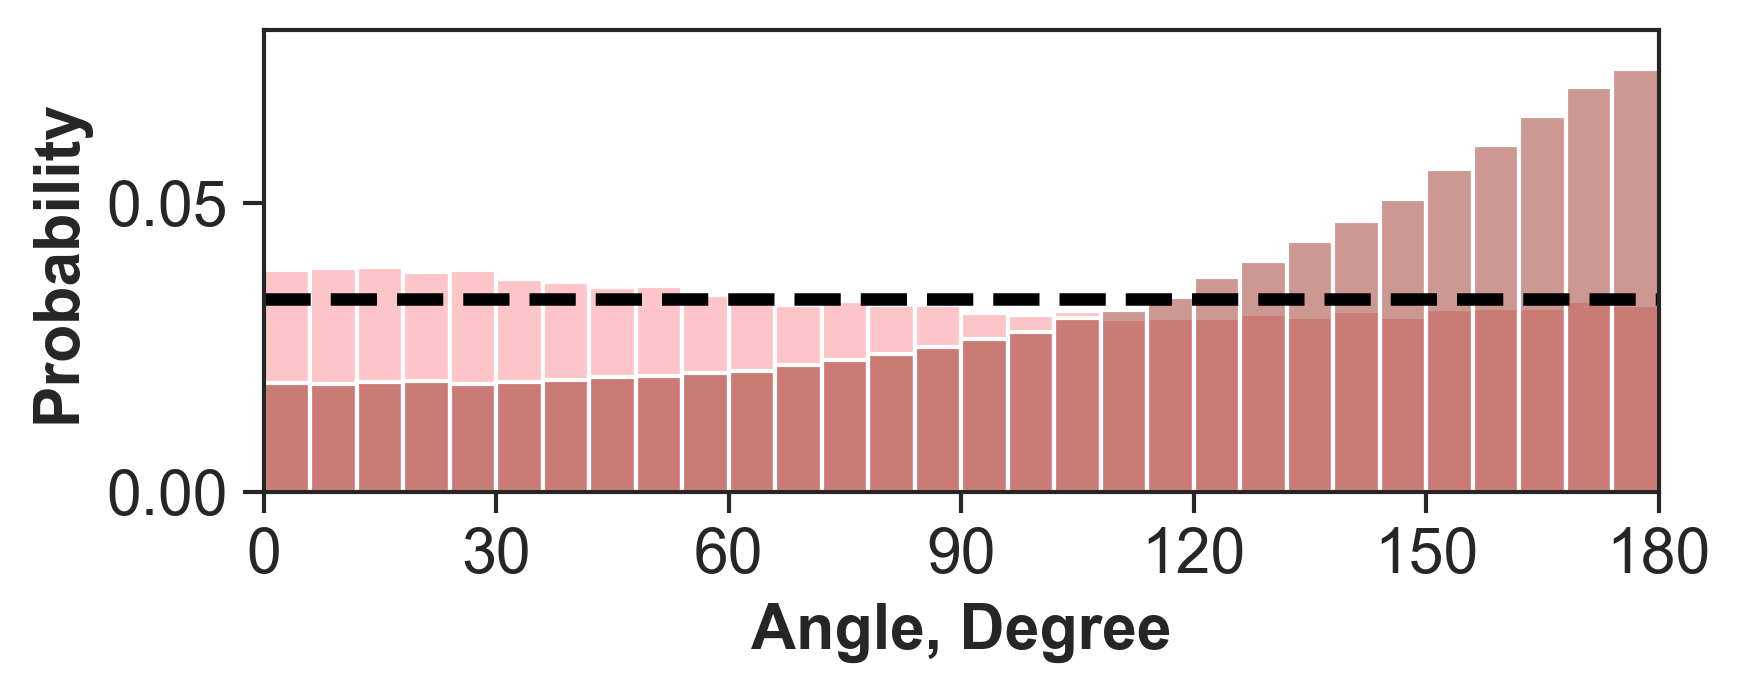

In [7]:
lst_angle = []
lst_label = []
for _, row in df_AIO[df_AIO["max_d_anytwo_nm"] > 200].iterrows():
    angles = np.fromstring(
        row["list_of_angles"][1:-1],
        dtype=float,
        sep=", ",
    )
    labels = np.repeat(row["label"], angles.shape[0])
    lst_angle.extend(angles)
    lst_label.extend(labels)

data = pd.DataFrame(
    {
        "angle": np.abs(lst_angle),
        "label": lst_label,
    },
    dtype=object,
)

plt.figure(figsize=(6, 2), dpi=300)
bins = 30
ax = sns.histplot(
    data=data,
    x="angle",
    hue="label",
    palette=palette,
    bins=bins,
    stat="probability",
    common_norm=False,
    binrange=(0, 180),
    alpha=0.5,
    legend=False,
)
# sns.move_legend(ax, 0, title=None, frameon=False)
plt.axhline(1 / bins, color="black", ls="--", lw=3)
plt.xlim(0, 180)
plt.xticks([0, 30, 60, 90, 120, 150, 180])
plt.ylim(0, 0.08)
plt.xlabel("Angle, Degree", weight="bold", fontsize=15)
plt.ylabel("Probability", weight="bold", fontsize=15)
plt.gca().spines[:].set_linewidth(1)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=15,
    direction="out",
    bottom=True,
    left=True,
    length=5,
    width=1,
)

plt.gca().tick_params(axis="both", which="major", labelsize=15)
plt.savefig("4.angle_histo_" + postfix, format="png", bbox_inches="tight")
plt.show()

### D distribution among the non contrained molecules

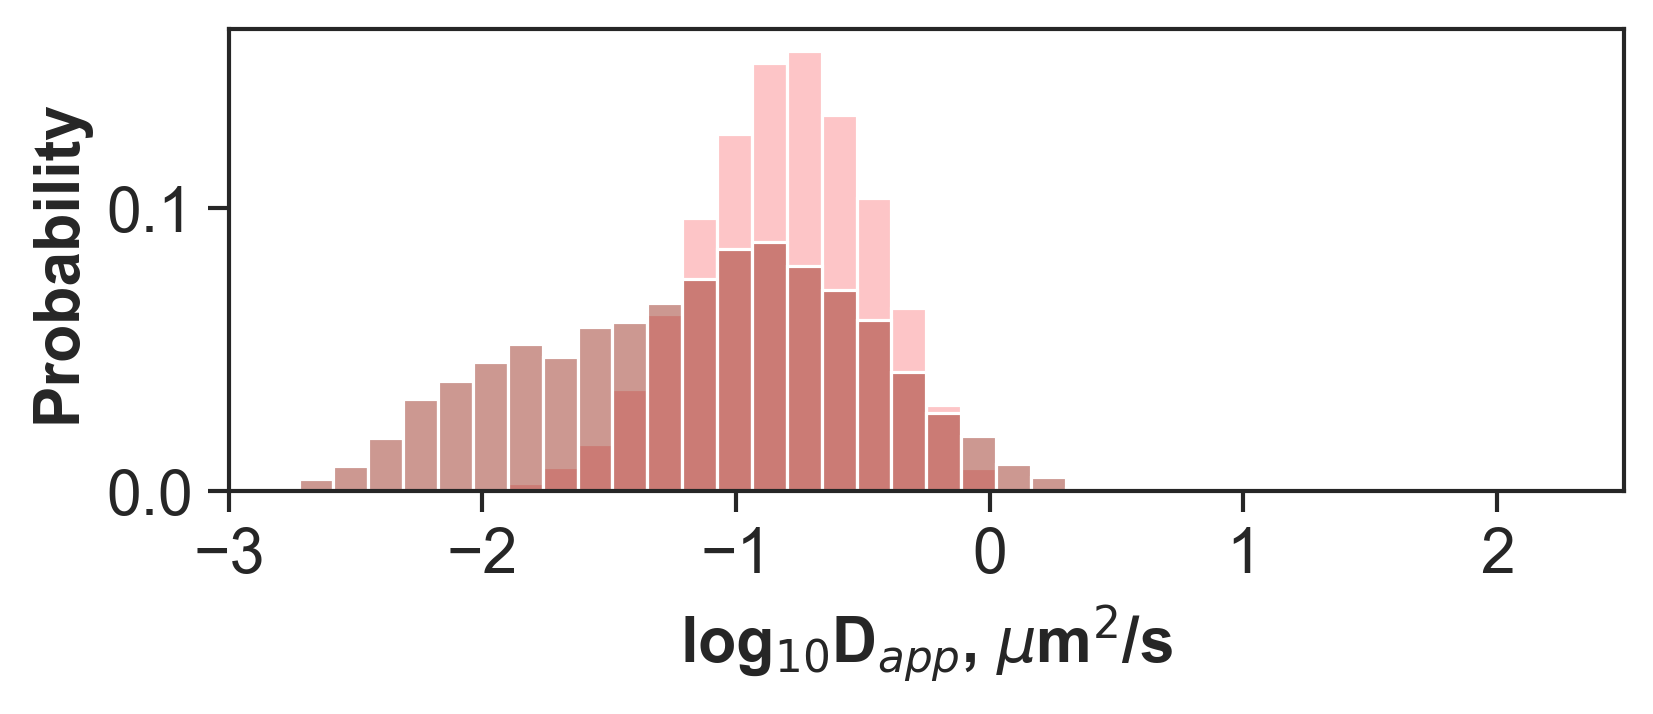

FL mRNA 7342
miRNA-21 12907


In [8]:
data = df_AIO[df_AIO["linear_fit_R2"] > 0.7]
data = data[data["max_d_anytwo_nm"] > threshold_max_d_anytwo_nm]
data = data[data["alpha"] > 0.5]
plt.figure(figsize=(6, 2), dpi=300)
ax = sns.histplot(
    data=data,
    x="linear_fit_log10D",
    hue="label",
    palette=palette,
    bins=40,
    stat="probability",
    common_norm=False,
    # kde=True,
    # kde_kws={"bw_adjust": 1.5},
    # line_kws={"lw": 3},
    binrange=(-3, 2.5),
    alpha=0.5,
    legend=False,
)
# sns.move_legend(ax, 1, title=None, frameon=False)
plt.xlim(-3, 2.5)
plt.xlabel(r"log$_{10}$D$_{app}$, $\mu$m$^2$/s", weight="bold", fontsize=15)
plt.ylabel("Probability", weight="bold", fontsize=15)
plt.gca().spines[:].set_linewidth(1)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=15,
    direction="out",
    bottom=True,
    left=True,
    length=5,
    width=1,
)
plt.gca().tick_params(axis="both", which="major", labelsize=15)
plt.savefig("5.ApparentD_linear_histo_" + postfix, format="png", bbox_inches="tight")
plt.show()
print(label_1, data[data["label"] == label_1].shape[0])
print(label_2, data[data["label"] == label_2].shape[0])

### Plot saSPT

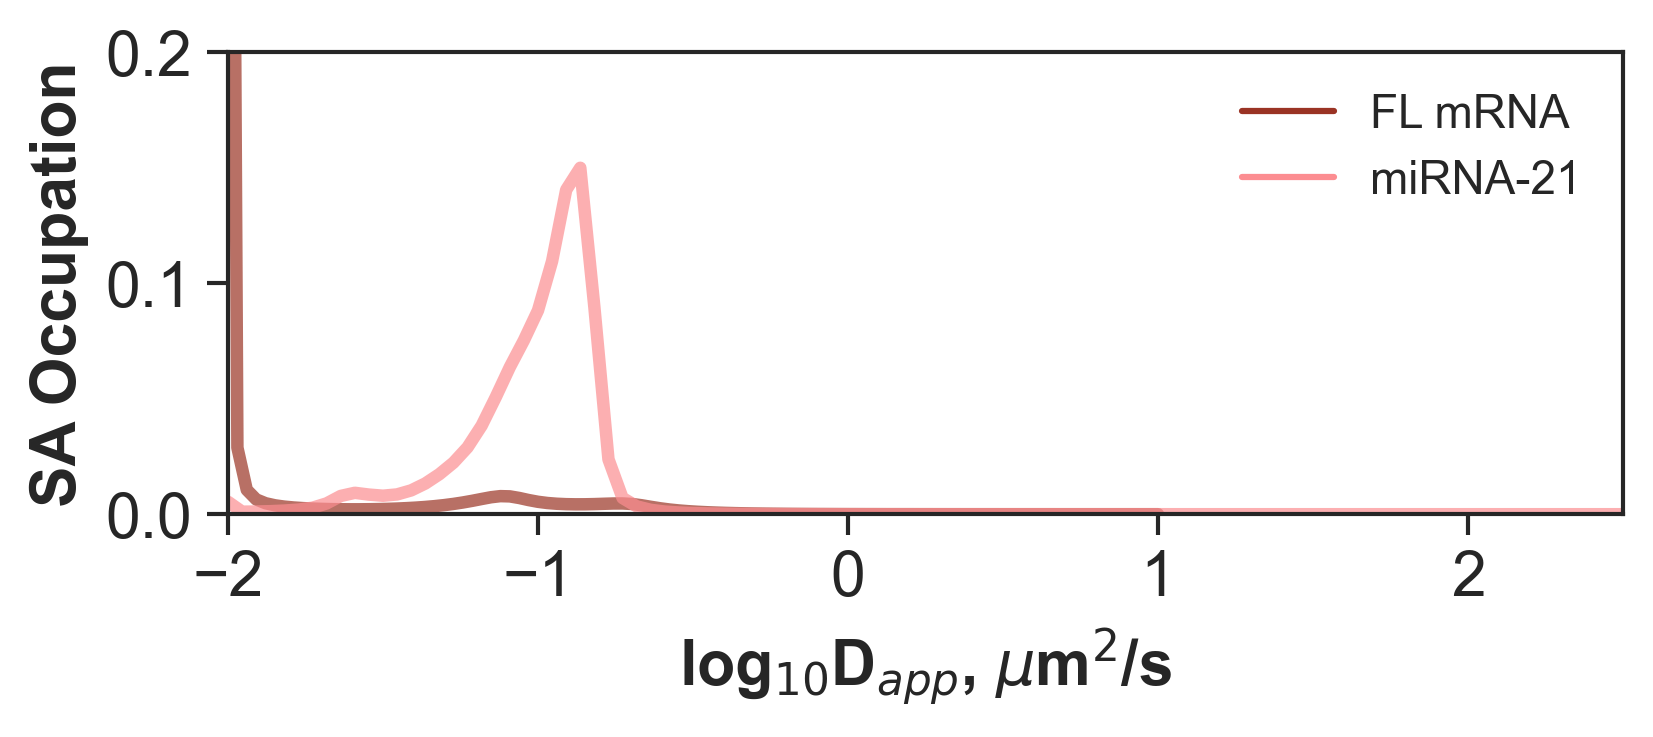

In [12]:
plt.figure(figsize=(6, 2), dpi=300)
ax = sns.lineplot(
    data=df_saspt,
    x="log10D",
    y="Probability",
    hue="label",
    palette=palette,
    lw=3,
    alpha=0.7,
)
log10D = df_saspt["log10D"].to_numpy(dtype=float)

sns.move_legend(ax, 1, title=None, frameon=False)
plt.xlim(log10D.min(), log10D.max())
plt.ylim(0, 0.2)
plt.xlabel(r"log$_{10}$D$_{app}$, $\mu$m$^2$/s", weight="bold", fontsize=15)
plt.ylabel("SA Occupation", weight="bold", fontsize=15)
plt.gca().spines[:].set_linewidth(1)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=15,
    direction="out",
    bottom=True,
    left=True,
    length=5,
    width=1,
)
plt.gca().tick_params(axis="both", which="major", labelsize=15)
plt.savefig("6.saspt_histo_" + postfix, format="png", bbox_inches="tight")
plt.show()

### Fitting R2 of all mobile molecules

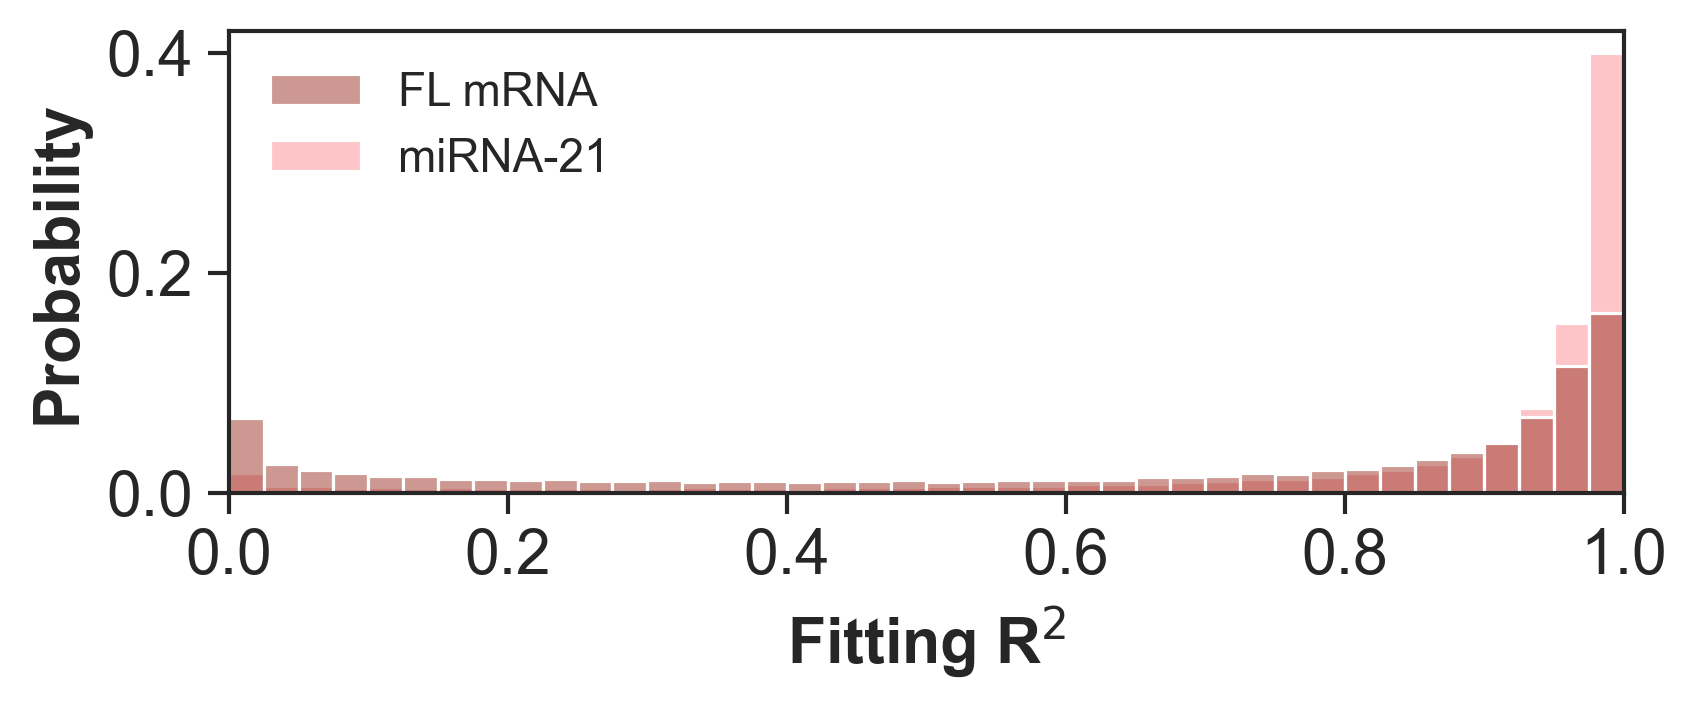

FL mRNA 19514
miRNA-21 16649


In [10]:
data = df_AIO[df_AIO["max_d_anytwo_nm"] > threshold_max_d_anytwo_nm]
plt.figure(figsize=(6, 2), dpi=300)
ax = sns.histplot(
    data=data,
    x="linear_fit_R2",
    hue="label",
    palette=palette,
    bins=40,
    stat="probability",
    common_norm=False,
    binrange=(0, 1),
)
sns.move_legend(ax, 0, title=None, frameon=False)
plt.xlim(0, 1)
plt.xlabel(r"Fitting R$^2$", weight="bold", fontsize=15)
plt.ylabel("Probability", weight="bold", fontsize=15)
plt.gca().spines[:].set_linewidth(1)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=15,
    direction="out",
    bottom=True,
    left=True,
    length=5,
    width=1,
)
plt.savefig("SM1.fitting_R2_histo_" + postfix, format="png", bbox_inches="tight")
plt.show()
print(label_1, data[data["label"] == label_1].shape[0])
print(label_2, data[data["label"] == label_2].shape[0])